In [260]:
import pandas as pd
import catboost
import lightgbm
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import json
import numpy as np

In [194]:
locations = ['bergen', 'oslo', 'stavanger', 'tromsø', 'trondheim']

df = pd.read_csv("consumption_temp.csv")
df = df[df["location"].isin(locations)]
df["y"] = df.groupby("location")[df.columns].shift(-5 * 24)["consumption"]
df = df.dropna()

In [211]:
# Add holiday flag

# Import holidays data
with open('helligdager2022.json') as data_file:    
    holidays_2022 = json.load(data_file)

with open('helligdager2023.json') as data_file:    
    holidays_2023 = json.load(data_file)  

holidays_2022 = pd.json_normalize(holidays_2022, 'data')
holidays_2023 = pd.json_normalize(holidays_2023, 'data')

holidays_2023["time"] = pd.to_datetime(holidays_2023["date"])
holidays_2022["time"] = pd.to_datetime(holidays_2022["date"])

# Merge into df
data = df.copy()

data["is_holiday"] = np.logical_or(
    np.isin(
        pd.to_datetime(data["time"]).dt.date, pd.to_datetime(holidays_2022["time"]).dt.date
    ),
    np.isin(
        pd.to_datetime(data["time"]).dt.date, pd.to_datetime(holidays_2023["time"]).dt.date
    ),
).astype(int)

df["is_holiday"] = data["is_holiday"]

In [ ]:
test_size = 0.1
train_size = 1 - test_size
window_size = 24  * 5

## Base Model

Use the day 0 to predict day +5. 
Then see difference between predicted +5 values and actual +5 values

In [ ]:
df["location"].unique()

Whole dataset

In [79]:
locations = ['bergen', 'oslo', 'stavanger', 'tromsø', 'trondheim']

total_mae = 0
total_rmse = 0
total_rows = 0  # to keep track of total number of rows across all locations

# For accuracy calculation
tolerance_percentage = 0.05  # 5% tolerance
accurate_predictions = 0

for location in locations:
    df_location = df[df["location"] == location]
    
    mae = sum(abs(df_location.iloc[i]["consumption"] - df_location.iloc[i+5]["consumption"]) 
              for i in range(len(df_location)-5))
    rmse = sum((df_location.iloc[i]["consumption"] - df_location.iloc[i+5]["consumption"])**2 
               for i in range(len(df_location)-5))
    
    for i in range(len(df_location)-5):
        predicted = df_location.iloc[i]["consumption"]
        actual = df_location.iloc[i+5]["consumption"]
        
        if (1 - tolerance_percentage) * predicted <= actual <= (1 + tolerance_percentage) * predicted:
            accurate_predictions += 1
    
    total_mae += mae
    total_rmse += rmse
    total_rows += len(df_location)  # update the total rows for each location

# Average out the MAE and RMSE
avg_mae = total_mae / total_rows
avg_mse = total_rmse / total_rows
avg_rmse = math.sqrt(total_rmse / total_rows)
accuracy = accurate_predictions / total_rows  # accuracy as a percentage

print(f"MAE: {avg_mae}")
print(f"MSE: {avg_mse}")
print(f"RMSE: {avg_rmse}")
print(f"Accuracy: {accuracy*100:.2f}%")


MAE: 0.3875180181597097
MSE: 0.3588300705337483
RMSE: 0.5990242653964432
Accuracy: 20.72%


Last 10% of dataset

In [81]:
locations = ['bergen', 'oslo', 'stavanger', 'tromsø', 'trondheim']
df = df.copy()

# only use last 10 % of df
data = df.iloc[int(len(df)*0.9):]

total_mae = 0
total_rmse = 0
total_rows = 0  # to keep track of total number of rows across all locations

# For accuracy calculation
tolerance_percentage = 0.05  # 5% tolerance
accurate_predictions = 0

for location in locations:
    df_location = data[data["location"] == location]
    
    mae = sum(abs(df_location.iloc[i]["consumption"] - df_location.iloc[i+5]["consumption"]) 
              for i in range(len(df_location)-5))
    rmse = sum((df_location.iloc[i]["consumption"] - df_location.iloc[i+5]["consumption"])**2 
               for i in range(len(df_location)-5))
    
    for i in range(len(df_location)-5):
        predicted = df_location.iloc[i]["consumption"]
        actual = df_location.iloc[i+5]["consumption"]
        
        if (1 - tolerance_percentage) * predicted <= actual <= (1 + tolerance_percentage) * predicted:
            accurate_predictions += 1
    
    total_mae += mae
    total_rmse += rmse
    total_rows += len(df_location)  # update the total rows for each location

# Average out the MAE, MSE and RMSE
avg_mae = total_mae / total_rows
avg_mse = total_rmse / total_rows
avg_rmse = math.sqrt(total_rmse / total_rows)
accuracy = accurate_predictions / total_rows  # accuracy as a percentage

print(f"MAE: {avg_mae}")
print(f"MSE: {avg_mse}")
print(f"RMSE: {avg_rmse}")
print(f"Accuracy: {accuracy*100:.2f}%")


MAE: 0.5846938560168352
MSE: 0.7070573746387248
RMSE: 0.8408670374314389
Accuracy: 22.76%


In [ ]:
total_rows

## Our Model

In [226]:
data = df.copy()

data["time"] = pd.to_datetime(data["time"])
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year
data["weekday"] = data["time"].dt.weekday
data["quarter"] = data["time"].dt.quarter
data["dayofyear"] = data["time"].dt.dayofyear
data["dayofweek"] = data["time"].dt.dayofweek
data["weekend"] = data["time"].dt.weekday.isin([5, 6]).astype(int)

data = data.sort_values("time").drop(columns=["time"])
data = data.reset_index(drop=True)

results = {}

X = data[[col for col in data.columns if col != "y"]]
y = data["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [281]:
# Catboost ----------------------------------------------

train_pool = catboost.Pool(
    X_train, y_train, cat_features=["location", "is_holiday", "month", "weekend"]
)
test_pool = catboost.Pool(
    X_test, cat_features=["location", "is_holiday", "month", "weekend"]
)

params = {
    # "border_count": 128,
    "depth": 8,
    # "iterations": 300,
    # "l2_leaf_reg": 1,
    # "learning_rate": 0.1,
}

catboost_model = catboost.CatBoostRegressor(**params)
catboost_model.fit(train_pool)

catboost_predictions = catboost_model.predict(test_pool)

Learning rate set to 0.072846
0:	learn: 2.9233663	total: 14.8ms	remaining: 14.8s
1:	learn: 2.7260572	total: 25.1ms	remaining: 12.5s
2:	learn: 2.5451731	total: 32.2ms	remaining: 10.7s
3:	learn: 2.3763321	total: 41.7ms	remaining: 10.4s
4:	learn: 2.2171087	total: 51.5ms	remaining: 10.2s
5:	learn: 2.0709914	total: 60.2ms	remaining: 9.98s
6:	learn: 1.9371935	total: 69.2ms	remaining: 9.82s
7:	learn: 1.8138411	total: 76.9ms	remaining: 9.53s
8:	learn: 1.7003980	total: 85.5ms	remaining: 9.42s
9:	learn: 1.5944289	total: 94.8ms	remaining: 9.38s
10:	learn: 1.4985502	total: 103ms	remaining: 9.28s
11:	learn: 1.4086753	total: 112ms	remaining: 9.23s
12:	learn: 1.3270314	total: 122ms	remaining: 9.27s
13:	learn: 1.2516594	total: 132ms	remaining: 9.3s
14:	learn: 1.1809767	total: 141ms	remaining: 9.29s
15:	learn: 1.1158365	total: 149ms	remaining: 9.15s
16:	learn: 1.0556749	total: 158ms	remaining: 9.15s
17:	learn: 1.0010579	total: 166ms	remaining: 9.05s
18:	learn: 0.9515976	total: 175ms	remaining: 9.03s
19

In [254]:
# LightGBM ----------------------------------------------

location_encoder = LabelEncoder()

X_train["location"] = location_encoder.fit_transform(X_train["location"])
X_test["location"] = location_encoder.fit_transform(X_test["location"])

train_pool = lightgbm.Dataset(
    X_train, y_train, categorical_feature=["location", "is_holiday", "month", "weekend"]
)
test_pool = lightgbm.Dataset(
    X_test, categorical_feature=["location", "is_holiday", "month", "weekend"]
)

lgb_params = {
    "learning_rate": 0.5,
    "metric": "mae",
    "n_estimators": 500,
    "num_leaves": 20,
    "objective": "regression",
    "random_state": 42,
}

lgb_model = lightgbm.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)

In [253]:
# Grid search param optimization on LightGBM ----------------------------------------------
from sklearn.model_selection import GridSearchCV

lgb_params = {
    "objective": "regression",
    "metric": "mae",
    "num_leaves": 5,
    "learning_rate": 0.01,
    "verbose": 0,
    "random_state": 42,
    "n_estimators": 1000
}

lgb_model = lightgbm.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)

gridParams = {
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [100, 200, 500],
    "num_leaves": [5, 10, 20],
    "objective": ["regression", "mae"],
    "metric": ["mae", "mse"],
    "random_state": [42]
}

grid = GridSearchCV(lgb_model, gridParams, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] 

In [289]:
ensemble_predictions = catboost_predictions * 0.4 + lgb_predictions * 0.6

metrics = pd.DataFrame(
    [
        [
            mean_absolute_error(y_test, lgb_predictions),
            mean_absolute_error(y_test, catboost_predictions),
            mean_absolute_error(y_test, ensemble_predictions),
            mean_absolute_error(y_test, X_test["consumption"]),
        ],
        [
            math.sqrt(mean_squared_error(y_test, lgb_predictions)),
            math.sqrt(mean_squared_error(y_test, catboost_predictions)),
            math.sqrt(mean_squared_error(y_test, ensemble_predictions)),
            math.sqrt(mean_squared_error(y_test, X_test["consumption"])),
        ],
    ],
    columns=["LightGBM", "Catboost", "Ensamble", "Baseline"],
    index=["MAE", "RMSE"],
)

metrics.T

,MAE,RMSE
LightGBM,0.148418,0.248230
Catboost,0.159162,0.259071
Ensamble,0.146660,0.242987
Baseline,0.375041,0.674115


In [ ]:
metrics

In [259]:
(0.37504112219907954 - 0.15312704120370194) / 0.37504112219907954

0.5917059966495648

In [257]:
0.37504112219907954/0.15312704120370194

2.449215496172029

In [173]:
data[data.location.isin(locations)][["consumption"]].iloc[int(len(data)*0.9):]

,consumption
38884,3.699234
38885,3.560206
38886,1.851444
38887,12.086788
38888,3.369316
...,...
43200,5.622820
43201,2.018333
43202,3.126721
43203,12.134655


In [163]:
results_df.sort_index()

,prediction
40,0.947991
41,3.032817
42,1.595548
43,1.055599
44,1.614047
...,...
48768,3.117208
48770,12.135717
48771,5.627349
48772,2.022139


In [139]:
predictions = model.predict(test_pool)

print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"RMSE: {mean_squared_error(y_test, predictions, squared=False)}")

MAE: 0.01882516268777899
MSE: 0.0022393353565985535
RMSE: 0.047321616166383765


In [111]:
actual_indices = y_test.index

## Comparison

In [84]:
# base model results
print(f"MAE: {avg_mae}")
print(f"MSE: {avg_mse}")
print(f"RMSE: {avg_rmse}")

# Our model results 
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"RMSE: {mean_squared_error(y_test, predictions, squared=False)}")

MAE: 0.5846938560168352
MSE: 0.7070573746387248
RMSE: 0.8408670374314389
MAE: 0.2664344423570062
MSE: 0.16073297580943485
RMSE: 0.4009151728351458


In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your values)
base_model = {
    'MAE': avg_mae,
    'MSE': avg_mse,
    'RMSE': avg_rmse
}

our_model = {
    'MAE': mean_absolute_error(y_test, predictions),
    'MSE': mean_squared_error(y_test, predictions),
    'RMSE': mean_squared_error(y_test, predictions, squared=False)
}

# Calculate percentage improvements
percentage_improvements = {
    metric: ((base_model[metric] - our_model[metric]) / base_model[metric]) * 100 
    for metric in base_model
}

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = np.arange(len(base_model))  # the label locations

# Plotting the bars
base_bars = ax.bar(ind - width/2, base_model.values(), width, label='Base Model', color='blue')
our_bars = ax.bar(ind + width/2, our_model.values(), width, label='Our Model', color='green')

# Annotating bars with percentage improvement
for i, metric in enumerate(percentage_improvements):
    improvement = percentage_improvements[metric]
    if improvement > 0:
        ax.text(i, our_model[metric] + 0.01, f'+{improvement:.1f}%', ha='center', color='green', fontweight='bold')
    else:
        ax.text(i, our_model[metric] + 0.01, f'{improvement:.1f}%', ha='center', color='red', fontweight='bold')

# Labeling, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(ind)
ax.set_xticklabels(base_model.keys())
ax.legend()

# Display the bar chart
plt.show()
provements[metric]
    ypos = our_model[metric] + 0.02 * base_model[metric]  # Adjust vertical offset based on your scale
    
    # Display percentage improvements
    if improvement > 0:
        ax.text(i + width/2, ypos, f'+{improvement:.1f}%', ha='center', color='green', fontweight='bold')
    else:
        ax.text(i + width/2, ypos, f'{improvement:.1f}%', ha='center', color='red', fontweight='bold')


IndentationError: unexpected indent (2662983331.py, line 51)

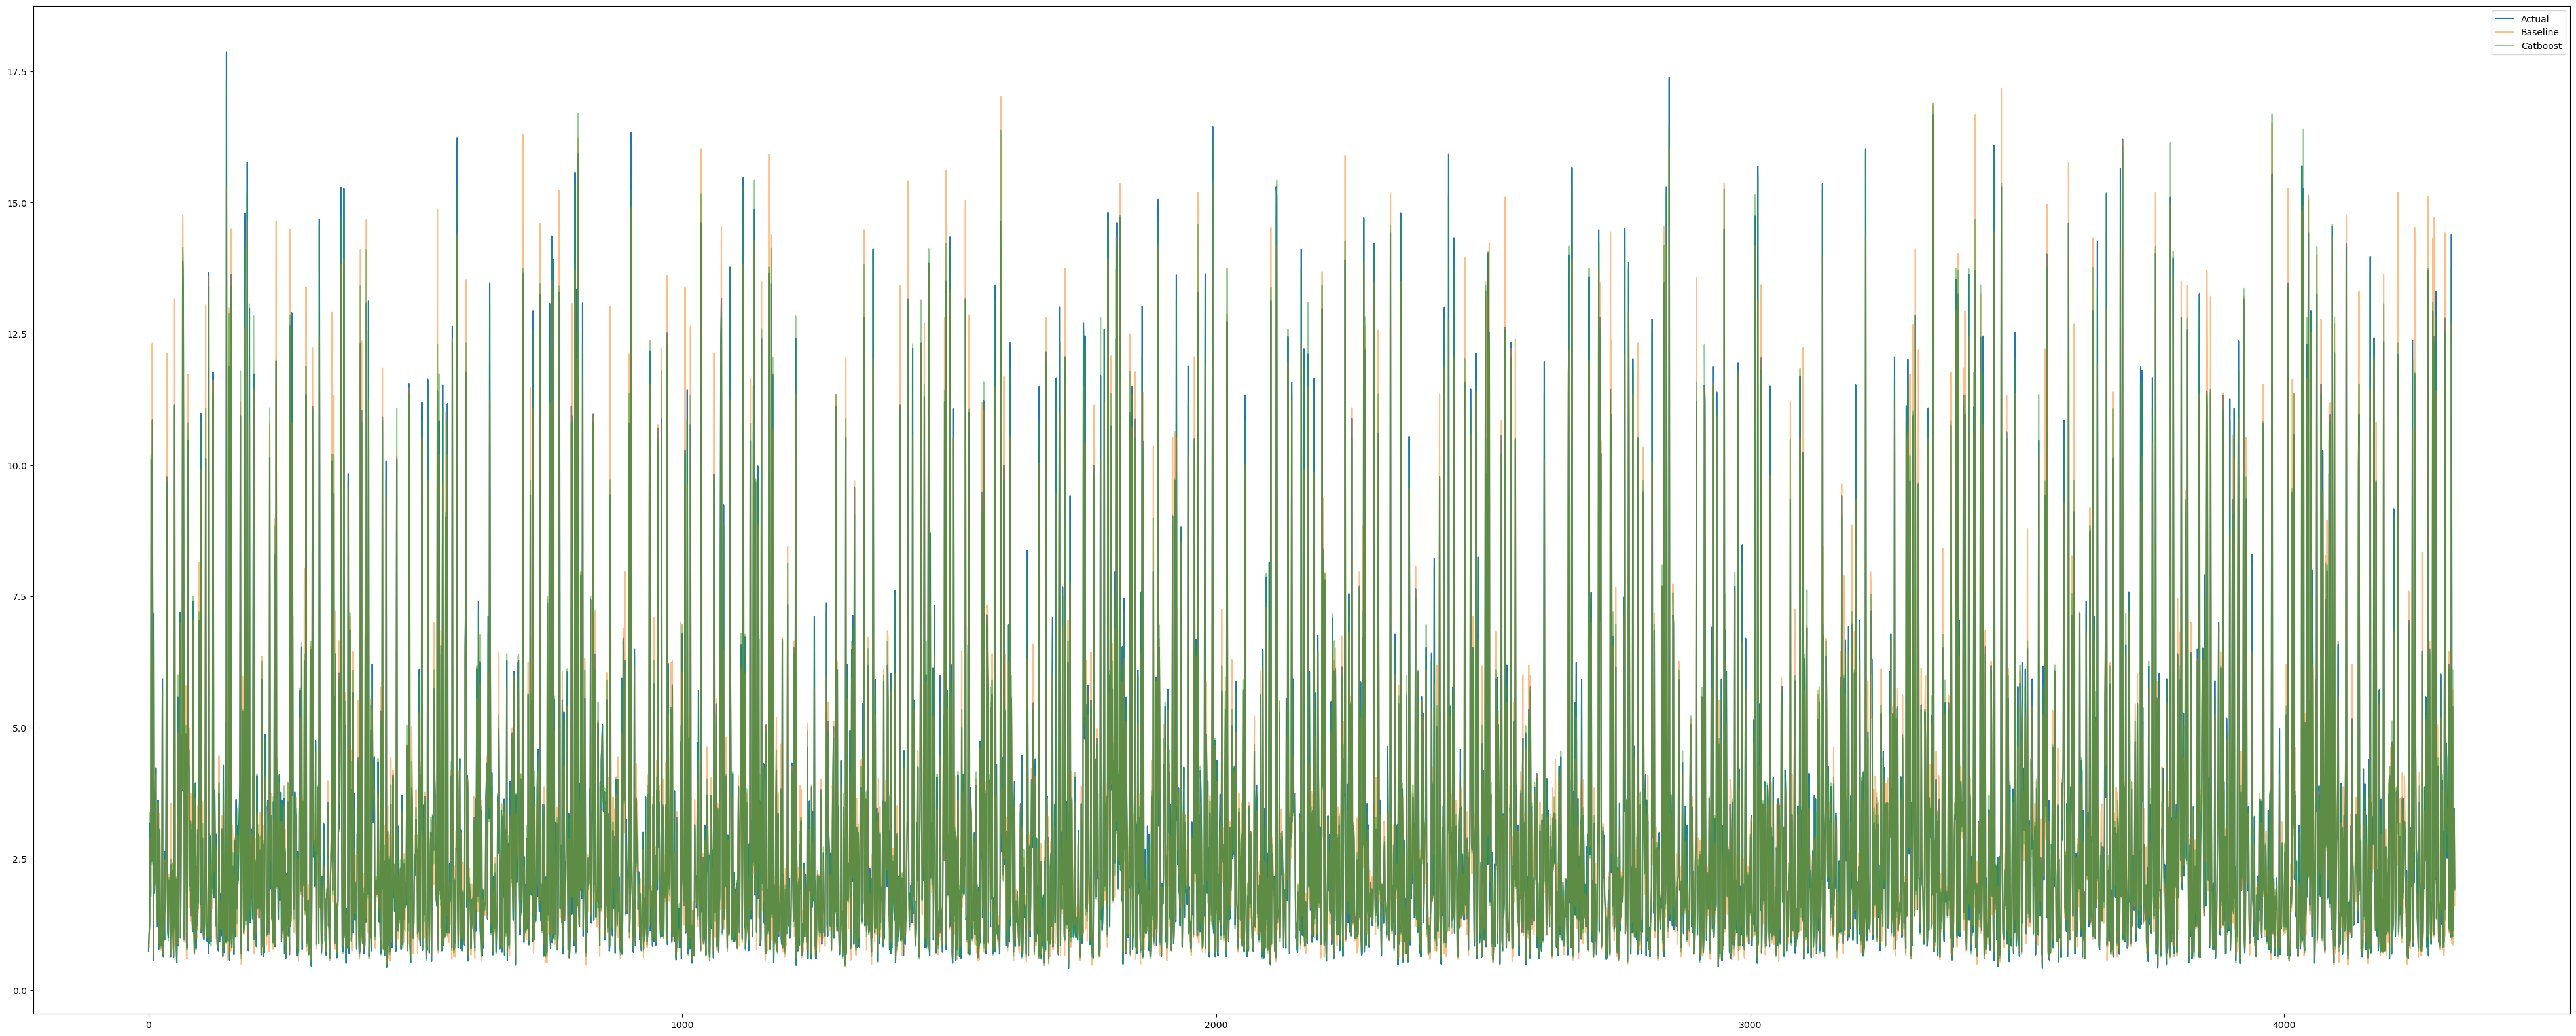

ValueError: Input contains NaN.

In [143]:
location = "A"

# Comparison with baseline

actuals = df.copy()["consumption"].iloc[actual_indices].reset_index(drop=True)

# Baseline model
baseline_predictions = df.copy()
baseline_predictions["consumption"] = baseline_predictions.groupby("location")["consumption"].shift(-5)
baseline_predictions = baseline_predictions.iloc[actual_indices].reset_index(drop=True)
baseline_predictions = baseline_predictions["consumption"]

# Catboost model
catboost_predictions = predictions

# Plot the results


plt.figure(figsize=(50, 20))
plt.plot(actuals, label="Actual")
plt.plot(baseline_predictions, label="Baseline", alpha=0.5)
plt.plot(catboost_predictions, label="Catboost", alpha=0.5)
plt.legend()
plt.show()


print(f"MAE: {mean_absolute_error(actuals, baseline_predictions)}")
print(f"MAE: {mean_absolute_error(actuals, catboost_predictions)}")

In [120]:
catboost_predictions.shape

(4320,)